#### import necessary libraries

In [175]:
import random
#our group number is 10, hence we use 10 as the random seed
random_seed = 10
random.seed(random_seed)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier



#### Read the dataset and show some basic information

In [176]:
bank = pd.read_csv('../data/bank-full.csv', sep=';')

In [177]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [178]:
#transfer y col to 0,1
le = LabelEncoder()
bank['y'] = le.fit_transform(bank['y'])

In [179]:
bank.shape

(45211, 17)

In [180]:
bank.describe()
#describe() only works on numerical columns, so we need to convert the categorical columns to numerical columns

,age,balance,day,duration,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [181]:
bank.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

In [182]:
#define columns that need to be converted to numerical columns 
#there are 10 categorical columns, so we need to convert them to numerical columns
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

In [183]:
#We use two methods to convert categorical columns to numerical columns: Label Encoding and One-Hot Encoding
#Different labeling methods have different effects on the model, so we need to try both methods
#copy the dataset
bank_label_encoded = bank.copy()
bank_ohe = bank.copy()

le = LabelEncoder()

#label Encoding
for col in categorical_cols:
    bank_label_encoded[col + '_label'] = le.fit_transform(bank_label_encoded[col])

#One-Hot Encoding
for col in categorical_cols:
    ohe = OneHotEncoder(drop='first', sparse_output=False)
    encoded_cols = ohe.fit_transform(bank_ohe[[col]])
    df_encoded = pd.DataFrame(encoded_cols, columns=ohe.get_feature_names_out([col]))
    bank_ohe = pd.concat([bank_ohe, df_encoded], axis=1).drop(columns=[col])
    


In [184]:
#only keep numerical columns
bank_label_encoded = bank_label_encoded.drop(columns=categorical_cols)
# move col y to the last
bank_label_encoded = bank_label_encoded[[c for c in bank_label_encoded if c not in ['y']] + ['y']]

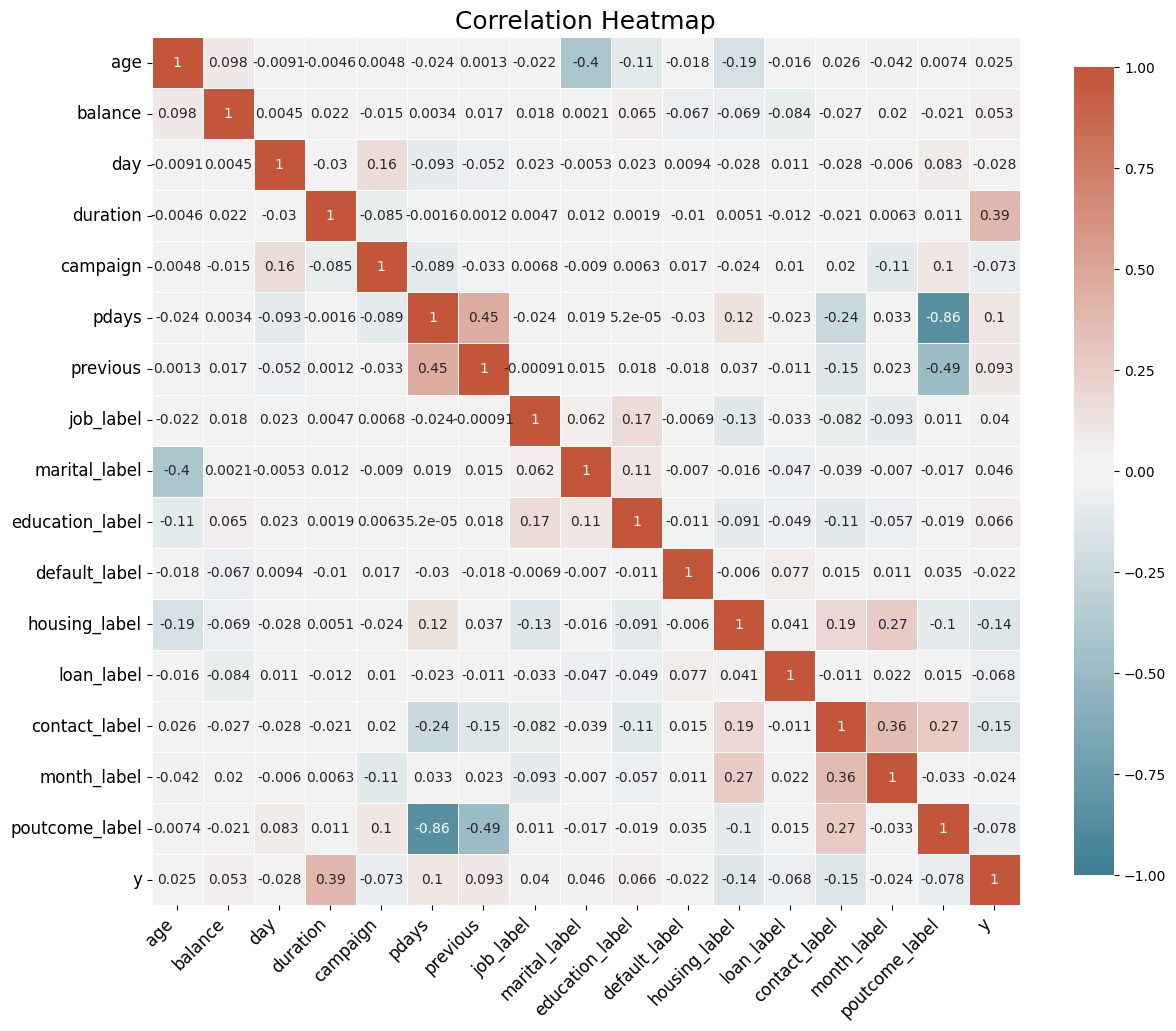

In [185]:
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 14, 14
rcParams['figure.dpi'] = 100

#correlation matrix
corr = bank_label_encoded.corr()

#plot the heatmap
ax = sns.heatmap(
    corr,
    annot=True,  
    linewidths=.5,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, sep=10, n=200),
    square=True,
    cbar_kws={"shrink": 0.75}
)

#set tick labels
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=12
)

ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize=12
)

plt.title('Correlation Heatmap', fontsize=18)

plt.show()

In [186]:
from sklearn.model_selection import train_test_split

#features and target
X_label = bank_label_encoded.drop(columns=['y'])
X_ohe = bank_ohe.drop(columns=['y'])
y = bank['y']

#### Split the data into train and test set

In [187]:
#split the dataset into train and test
X_train_label, X_test_label, y_train, y_test = train_test_split(X_label, y, test_size=0.2, random_state=random_seed)
X_train_ohe, X_test_ohe, _, _ = train_test_split(X_ohe, y, test_size=0.2, random_state=random_seed)

In [193]:
X_test_label.head()

,age,balance,day,duration,campaign,pdays,previous,job_label,marital_label,education_label,default_label,housing_label,loan_label,contact_label,month_label,poutcome_label
4393,55,0,20,365,4,-1,0,9,0,1,0,1,0,2,8,3
4438,31,1820,20,68,1,-1,0,6,2,2,0,1,0,2,8,3
11108,28,2253,18,906,2,-1,0,4,2,2,0,1,0,2,6,3
35421,28,7449,7,193,1,-1,0,9,1,1,0,1,0,0,8,3
2667,43,59,13,437,2,-1,0,2,1,1,0,0,0,2,8,3


In [190]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
    'Bagging': BaggingClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}


#capture all CV scores
results_label_encoded_all = {key: [] for key in models.keys()}
results_ohe_all = {key: [] for key in models.keys()}

for name, model in models.items():
    scores_label = cross_val_score(model, X_train_label, y_train, cv=5, scoring='accuracy')
    scores_ohe = cross_val_score(model, X_train_ohe, y_train, cv=5, scoring='accuracy')
    
    results_label_encoded_all[name] = scores_label
    results_ohe_all[name] = scores_ohe

#convert to dataframes
df_label_encoded = pd.DataFrame(results_label_encoded_all)
df_ohe = pd.DataFrame(results_ohe_all)

#show the results
print("Label Encoded Results:")
display(df_label_encoded)

print("\nOne-Hot Encoded Results:")
display(df_ohe)


Label Encoded Results:


,Logistic Regression,K-Nearest Neighbors,Decision Tree,SVM,Gaussian Naive Bayes,Random Forest,Bagging,Gradient Boosting,XGBoost
0,0.893696,0.884435,0.873099,0.882914,0.846143,0.905999,0.902820,0.905999,0.905723
1,0.887338,0.879458,0.869782,0.882914,0.844761,0.902405,0.895355,0.904202,0.903649
2,0.888720,0.880426,0.863837,0.882638,0.846005,0.905585,0.896738,0.903511,0.903235
3,0.889258,0.878335,0.863680,0.882207,0.845431,0.901839,0.891746,0.900180,0.903221
4,0.889534,0.877229,0.871146,0.882207,0.836029,0.903498,0.896723,0.902807,0.906401



One-Hot Encoded Results:


,Logistic Regression,K-Nearest Neighbors,Decision Tree,SVM,Gaussian Naive Bayes,Random Forest,Bagging,Gradient Boosting,XGBoost
0,0.905723,0.884435,0.877523,0.882914,0.861764,0.908902,0.902544,0.908073,0.908764
1,0.901161,0.879873,0.868952,0.883052,0.865082,0.905447,0.899364,0.906967,0.901438
2,0.905032,0.881117,0.872270,0.882776,0.862732,0.902544,0.897982,0.904479,0.904064
3,0.898106,0.879027,0.870317,0.882207,0.859256,0.901839,0.896447,0.903498,0.902807
4,0.900318,0.876953,0.870317,0.882207,0.861468,0.905572,0.900733,0.903498,0.903913


In [191]:
avg_accuracy_label_encoded = df_label_encoded.mean()
avg_accuracy_ohe = df_ohe.mean()

print("Average Accuracy for Label Encoded Data:")
print(avg_accuracy_label_encoded)

print("\n")

print("Average Accuracy for One-Hot Encoded Data:")
print(avg_accuracy_ohe)

Average Accuracy for Label Encoded Data:
Logistic Regression     0.889709
K-Nearest Neighbors     0.879977
Decision Tree           0.868309
SVM                     0.882576
Gaussian Naive Bayes    0.843674
Random Forest           0.903865
Bagging                 0.896676
Gradient Boosting       0.903340
XGBoost                 0.904446
dtype: float64


Average Accuracy for One-Hot Encoded Data:
Logistic Regression     0.902068
K-Nearest Neighbors     0.880281
Decision Tree           0.871876
SVM                     0.882631
Gaussian Naive Bayes    0.862060
Random Forest           0.904861
Bagging                 0.899414
Gradient Boosting       0.905303
XGBoost                 0.904197
dtype: float64


In [209]:
import plotly.graph_objects as go

df_label_long = df_label_encoded.melt(var_name='Model', value_name='Accuracy')
df_ohe_long = df_ohe.melt(var_name='Model', value_name='Accuracy')

#create box plots
trace1 = go.Box(
    y=df_label_long['Accuracy'],
    x=df_label_long['Model'],
    name='Label Encoded',
    marker=dict(color='blue')
)

trace2 = go.Box(
    y=df_ohe_long['Accuracy'],
    x=df_ohe_long['Model'],
    name='One-Hot Encoded',
    marker=dict(color='red')
)

layout = go.Layout(
    title='Model Performance Comparison Across CV Folds',
    xaxis=dict(title='Model'),
    yaxis=dict(title='Accuracy'),
    boxmode='group',
    template='plotly_white'
)

#show the figure
fig_1 = go.Figure(data=[trace1, trace2], layout=layout)
fig_1.show()

In [210]:
#save the figure
fig_1.write_html("box_plot_accuracy_all_models.html")

According to the plot and the output above, we can see that X_ohe(One-Hot encoding) have a better performance than X_le(Label encoding). So we will use X_ohe as our input data.

In [199]:
#pick the best 4 models and use logoistic regression to be the final estimator
from sklearn.ensemble import StackingClassifier

#remove Logistic Regression from the dictionary because it will be the final estimator
if 'Logistic Regression' in avg_accuracy_ohe:
    avg_accuracy_ohe = avg_accuracy_ohe.drop('Logistic Regression')


sorted_models = sorted(avg_accuracy_ohe.keys(), key=lambda x: avg_accuracy_ohe[x], reverse=True)[:4]
top_models = [(name, models[name]) for name in sorted_models]

stacked_model = StackingClassifier(estimators=top_models, 
                                   final_estimator=LogisticRegression(max_iter=10000))

stacked_model.fit(X_train_ohe, y_train)

all_models = top_models.copy()
all_models.append(('Stacked Classifier', stacked_model))

In [200]:
#train the models
results_ohe_stacked = {name: [] for name, _ in all_models}

for name, model in all_models:
    scores_ohe = cross_val_score(model, X_train_ohe, y_train, cv=5, scoring='accuracy')
    results_ohe_stacked[name] = scores_ohe

#convert to dataframe
df_ohe_stacked = pd.DataFrame(results_ohe_stacked)

avg_accuracy_ohe_stacked = df_ohe_stacked.mean()
print("Average Accuracy for One-Hot Encoded Data with Stacked Model:")
print(avg_accuracy_ohe_stacked)

Average Accuracy for One-Hot Encoded Data with Stacked Model:
Gradient Boosting     0.905303
Random Forest         0.903450
XGBoost               0.904197
Bagging               0.896815
Stacked Classifier    0.906824
dtype: float64


In [211]:
#plot the results using Plotly
fig_2 = go.Figure()

for col in df_ohe_stacked.columns:
    fig_2.add_trace(go.Box(y=df_ohe_stacked[col], name=col, boxmean=True))

fig_2.update_layout(
    title="Model Accuracy Distribution",
    xaxis_title="Model",
    yaxis_title="Accuracy",
    showlegend=False,
    template="plotly_white"
)

fig_2.show()

In [217]:
fig_2.write_html("box_plot_accuracy_stacked_model.html")

#### export the model, and re-import it again, then use it to predict the test data.

In [202]:
import pickle
#save the stacked model
filename = 'stacked_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(stacked_model, file)

In [203]:
#load the model
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)


Accuracy: 90.89%
Confusion Matrix:
[[7733  261]
 [ 563  486]]
Plot saved as confusion_matrix_plot.png


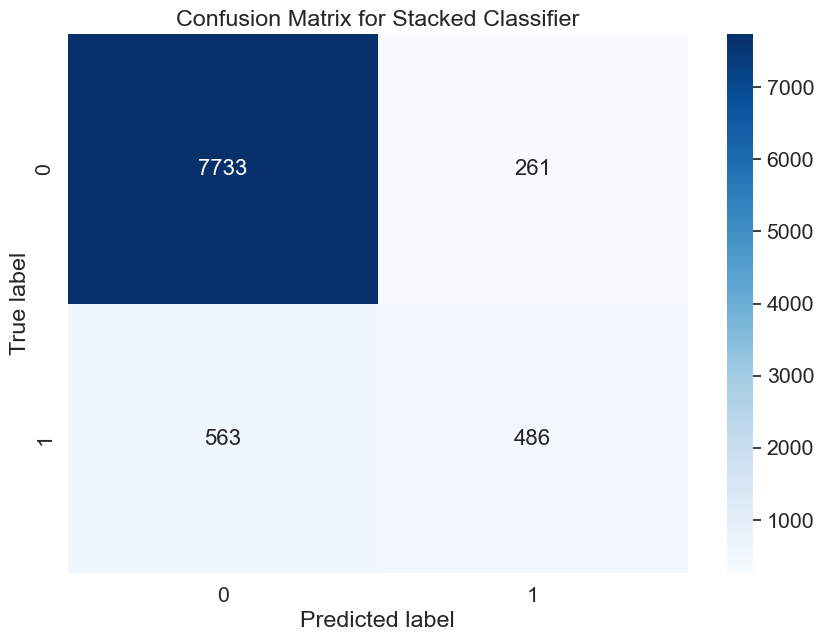

In [216]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

y_pred = loaded_model.predict(X_test_ohe)

#calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

#get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

#show the cm using seaborn
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt='g') # annot_kws is for the annotation size
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Stacked Classifier')

file_name = "confusion_matrix_plot.png"
plt.savefig(file_name, dpi=300, bbox_inches='tight')
print(f"Plot saved as {file_name}")

plt.show()


In [215]:
#save the figure
plt.savefig("confusion_matrix_stacked_model.png")

<Figure size 1400x1400 with 0 Axes>